In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**0. Thư viện**

##Cài đặt 

In [ ]:
!pip3 install adabound
# !pip3 numpy torc sklearn matplotlib pandas

##Import

In [ ]:
# Add Module Path - To Import Custom Modules
# Modules Path
ModulePath = "/content/drive/My Drive/Study/KLTN/Google Colab/0.0 Python Modules/"

import sys
sys.path.append(ModulePath)

In [ ]:
import numpy as np
import pandas as pd
import torch as th
from torch.autograd import Variable as V
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import pickle

# Libs for Keras
from keras.models import load_model


# Own Custom Module to import models and constants
from models import *
from constants import *

import matplotlib.pyplot as plt
import adabound 
import math
import os
from datetime import date
import timeit

Using TensorFlow backend.


#**1. Chuẩn bị**

##Paths

In [ ]:
# Base Path
base_path = "/content/drive/My Drive/Study/KLTN/"
Dataset_Path = base_path + "Dataset/NSL-KDD Processed/Final - For Using/"
SavedModelPath = base_path + "Saved Model/"

# Dataset Path
Trainsets_Path = Dataset_Path + 'Trainset/'
g_trainset_path = Trainsets_Path + "GAN-G.csv"
d_trainset_path = Trainsets_Path + "GAN-D.csv"
testset_path = Dataset_Path + "Testset/" + "KDDTest+.csv"


# GAN Saved Models Paths
GAN_Model_Path = SavedModelPath + 'GANModel/'

# IDS Pytorch Saved Models Paths
IDS_Saved_Path = SavedModelPath + 'IDSModel/'

##Global Variables

In [ ]:
# Global Variables
N_FEATURES = 41
# IDS
IDS_INPUT_DIM = N_FEATURES
IDS_OUTPUT_DIM = 2
ATTACK_CATEGORIES = ['DOS', 'U2R_AND_R2L']

POS_FUNCTIONAL_FEATURES = {'DOS': DOS_FEATURES, 'U2R_AND_R2L': U2R_AND_R2L_FEATURES}
POS_NONFUNCTIONAL_FEATURES = {}
for attack_category, pos_functional_feature in POS_FUNCTIONAL_FEATURES.items():
    pos_nonfunctional_feature = []
    for i in range(N_FEATURES):
        if i not in pos_functional_feature:
            pos_nonfunctional_feature.append(i)
    POS_NONFUNCTIONAL_FEATURES[attack_category] = pos_nonfunctional_feature

IDS_MODELS = {'GaussianNB', 'MultinomialNB', 'ComplementNB', 'BernoulliNB', 'DT', 'RF', 'KNN'}

In [ ]:
print('Position of Functional Features\n  ', POS_FUNCTIONAL_FEATURES)
print('Position of Functional Features:\n  ', POS_NONFUNCTIONAL_FEATURES)

Position of Functional Features
   {'DOS': [0, 1, 2, 3, 4, 5, 6, 7, 8, 23, 24, 25, 26, 27, 28, 29, 30], 'U2R_AND_R2L': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]}
Position of Functional Features:
   {'DOS': [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40], 'U2R_AND_R2L': [23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]}


# **2. Định nghĩa Model**

##Models

In [ ]:
# Load from model.py module

##Functions

### Processing Data Functions

In [ ]:
# Processing Data Functions
# create_batch2 - Hàm tạo Batch
def create_batch2(x,batch_size):
    a = list(range(len(x)))
    np.random.shuffle(a)
    x = x[a]
    batch_x = [x[batch_size * i : (i+1)*batch_size,:] for i in range(len(x)//batch_size)]
    return np.array(batch_x)
# preprocess_malicious_data - Hàm tiền xử lý dữ liệu tấn công
def preprocess_malicious_data(dataset, attack_category):
    if attack_category != 'DOS' and attack_category != 'U2R_AND_R2L':
      raise ValueError("Preprocess Data Fail: Invalid Attack Category")
    attack_data = dataset[dataset['class'] == attack_category]
    del attack_data["class"]
    return np.array(attack_data)

### IDS Functions

In [ ]:
# IDS Functions
# get_sklearn_ids_path - Get path for sklearn IDS Models
def get_sklearn_ids_path(model_name, attack_category, created_date):
    if attack_category != 'DOS' and attack_category != 'U2R_AND_R2L':
        raise ValueError("Preprocess Data Fail: Invalid Attack Category")
    ids_path = str(f"{IDS_Saved_Path}{attack_category}/Machine_Learning/created_date_{created_date}_{model_name}.pkl")
    if not os.path.exists(ids_path):
        raise ValueError(f"Invalid path: {ids_path}\nNot exist file!")
    return ids_path
# load_pytorch_ids_model - Load PyTorch IDS Models
def load_sklearn_ids_model(model_name, attack_category, created_date):
    ids_model_path = get_sklearn_ids_path(model_name, attack_category, created_date)
    with open(ids_model_path, 'rb') as file:
        pickle_model = pickle.load(file)
        print(f"Loaded Model From Disk: {ids_model_path}")
    return pickle_model

### GAN Functions

In [ ]:
# GAN Functions
# init_generator - Khoi tao model GAN-G
def init_generator(input_dim, output_dim, adversarial_attack_type = 1):
    if adversarial_attack_type == 1:
        generator = Generator_A1(input_dim, output_dim)
    elif adversarial_attack_type == 2:
        generator = Generator_A2(input_dim, output_dim)
    else:
        raise ValueError("Init GAN - Generator: Invalid Adversarial Attack Type")
    return generator

# gen_adversarial_attack - Tao luu luong tan cong doi khang
def gen_adversarial_attack(generator, noise_dim, raw_attack, attack_category, adversarial_attack_type = 1):
    if adversarial_attack_type == 1:
        adversarial_attack = generator(noise_dim, raw_attack, attack_category, POS_NONFUNCTIONAL_FEATURES)
    elif adversarial_attack_type == 2:
        batch_size = len(raw_attack)
        noise = V(th.Tensor(np.random.uniform(0,1,(batch_size, noise_dim))))
        generator_out = generator(noise)
        adversarial_attack = gen_adversarial_attack_a2(generator_out, raw_attack, attack_category, POS_NONFUNCTIONAL_FEATURES)
    else:
        raise ValueError("Init GAN - Generator: Invalid Adversarial Attack Type")
    return adversarial_attack

# train_generator - Train Generator
def train_generator(generator, discriminator, optimizer_G, noise_dim, attack_traffic, attack_category, adversarial_attack_type):
    for p in discriminator.parameters():  
        p.requires_grad = False
    optimizer_G.zero_grad()        
    # GAN-G Generate Adversarial Attack
    adversarial_attack = gen_adversarial_attack(generator, noise_dim, attack_traffic, attack_category, adversarial_attack_type)
    # GAN-D predict, GAN-G update parameter
    D_pred = discriminator(adversarial_attack)
    g_loss = -th.mean(D_pred)
    g_loss.backward()
    optimizer_G.step()
    return g_loss

# train_discriminator - Train Discriminator
def train_discriminator(discriminator, ids_model, generator, critic_iters, clamp, optimizer_D, normal_b, noise_dim, attack_traffic, attack_category, adversarial_attack_type):
    run_d_loss = 0
    cnt = 0
    for p in discriminator.parameters(): 
        p.requires_grad = True
    for c in range(critic_iters):
        optimizer_D.zero_grad()
        for p in discriminator.parameters():
            p.data.clamp_(-clamp, clamp)
        # GAN-G Generate Adversarial Attack
        adversarial_attack = gen_adversarial_attack(generator, noise_dim, attack_traffic, attack_category, adversarial_attack_type)
        # Make data to feed IDS
        ids_input = th.cat((adversarial_attack,normal_b))
        l = list(range(len(ids_input)))
        np.random.shuffle(l)
        ids_input = V(th.Tensor(ids_input[l]))
        # IDS Predict
        ids_pred_label = V(th.Tensor(ids_model.predict(ids_input)))
        pred_normal = ids_input[ids_pred_label==0]
        pred_attack = ids_input[ids_pred_label==1]
        if len(pred_attack) == 0:
            cnt += 1
            break
        # Make GAN-D input
        D_noraml = discriminator(V(th.Tensor(pred_normal)))
        D_attack= discriminator(V(th.Tensor(pred_attack)))
        # Loss and Update Parameter
        loss_normal = th.mean(D_noraml)
        loss_attack = th.mean(D_attack)
        gradient_penalty = compute_gradient_penalty(discriminator, normal_b.data, adversarial_attack.data)
        d_loss = loss_attack - loss_normal #+ LAMBDA * gradient_penalty
        d_loss.backward()
        optimizer_D.step()
        run_d_loss += d_loss.item()
    return run_d_loss, cnt

# compute_gradient_penalty - Compute Gradient Penalty
def compute_gradient_penalty(D, normal_t, attack_t):
    alpha = th.Tensor(np.random.random((normal_t.shape[0], 1)))
    between_n_a = (alpha * normal_t + ((1 - alpha) * attack_t)).requires_grad_(True)
    d_between_n_a = D(between_n_a)
    adv = V(th.Tensor(normal_t.shape[0], 1).fill_(1.0), requires_grad=False)

    gradients = autograd.grad(
        outputs=d_between_n_a,
        inputs=between_n_a,
        grad_outputs=adv,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

### Generate Adversarial Attack Functions

In [ ]:
# cal_dr - Tinh DR
def cal_dr(ids_model, normal, raw_attack, adversarial_attack):
    # Make data to feed IDS contain: Attack & Normal
    o_ids_input = th.cat((raw_attack, normal))
    a_ids_input = th.cat((adversarial_attack,normal))
    # Shuffle Input
    l = list(range(len(a_ids_input)))
    np.random.shuffle(l)
    o_ids_input = o_ids_input[l]
    a_ids_input = a_ids_input[l]
    # IDS Predict Label
    o_pred_label = th.Tensor(ids_model.predict(o_ids_input))
    a_pred_label = th.Tensor(ids_model.predict(a_ids_input))
    # True Label
    ids_true_label = np.r_[np.ones(BATCH_SIZE),np.zeros(BATCH_SIZE)][l]
    # Calc DR
    tn1, fn1, fp1, tp1 = confusion_matrix(ids_true_label,o_pred_label).ravel()
    tn2, fn2, fp2, tp2 = confusion_matrix(ids_true_label,a_pred_label).ravel()
    origin_dr = tp1/(tp1 + fp1)
    adversarial_dr = tp2/(tp2 + fp2)
    return origin_dr, adversarial_dr

# **3. Run Model**

In [ ]:
ids_model_name = "RF" #@param ['GaussianNB', 'MultinomialNB', 'ComplementNB', 'BernoulliNB', 'DT', 'RF', 'KNN']
MAX_EPOCH = 100 #@param ["10", "100"] {type:"raw"}

##**3.1 Run IDSGAN**

In [ ]:
# Hyber Parameters
BATCH_SIZE = 64
learning_rate = 0.0001
LAMBDA = 10
CLAMP = 0.01
CRITIC_ITERS = 5          # For WGAN and WGAN-GP, number of critic iters per gen iter

# GAN-D
D_INPUT_DIM = N_FEATURES
D_OUTPUT_DIM = 1
discriminator = Discriminator(D_INPUT_DIM,D_OUTPUT_DIM)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=learning_rate)

# GAN-G
NOISE_DIM = 9
G_INPUT_DIM = NOISE_DIM     # Generator input dimension is dimention of noise

In [ ]:
# ids_created_date
ids_created_date = '2020-07-08'

# Get today to set created time for GAN models
today = str(date.today())

## Prepare Dataset
g_train_data = pd.read_csv(g_trainset_path)
d_train_data = pd.read_csv(d_trainset_path)

# All normal record in train_data
del d_train_data["class"]
normal = np.array(d_train_data)

print("Amout of Generator Trainset:", g_train_data.shape[0])
print("Amout of Discriminator Trainset:", d_train_data.shape[0])

Amout of Generator Trainset: 23488
Amout of Discriminator Trainset: 33672


======================================== TRAINING GAN ========================================
 IDS Model: RF
********************************************************************************
 Attack Category: U2R_AND_R2L
--------------------------------------------------------------------------------
 Adversarial Attack Type : 2
Loaded Model From Disk: /content/drive/My Drive/Study/KLTN/Saved Model/IDSModel/U2R_AND_R2L/Machine_Learning/created_date_2020-07-08_RF.pkl
-->IDSGAN start training
     Epoch          G-Loss          D-Loss         O-DR(%)         A-DR(%)      Runtime(s)
         1           -2.82           -2.44           89.07           27.43           56.36
         2           -2.93           -2.29           89.07           27.36           55.79
         3           -2.73           -2.04           89.07           27.44           55.77
         4            4.11           -1.80           89.07           24.88           56.25
         5           -4.14           -1.67       

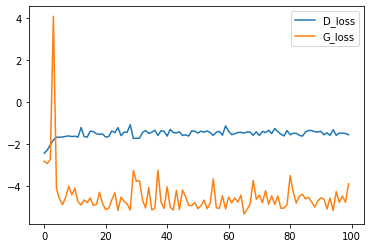

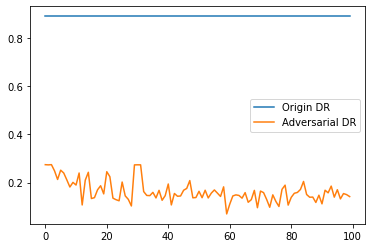

      -> Saved Discrimninator 100 epoch to: /content/drive/My Drive/Study/KLTN/Saved Model/GANModel/RF/U2R_AND_R2L/Discriminator/2/101epoch_time_created_2020-07-10.pth


In [ ]:
print(f"{40*'='} TRAINING GAN {40*'='}")
print(f"{80*'='}\n IDS Model: {ids_model_name}")
# for attack_category in ATTACK_CATEGORIES:
for attack_category in ['U2R_AND_R2L']:
    print(f"{80*'*'}\n Attack Category: {attack_category}")
    for adversarial_attack_type in [2]:
        total_time_start = timeit.default_timer()
        print(f"{80*'-'}\n Adversarial Attack Type : {adversarial_attack_type}")

        # Load sklearn IDS Model
        ids_model = load_sklearn_ids_model(ids_model_name, attack_category, ids_created_date)
        # Init GAN-G model
        G_OUTPUT_DIM = len(POS_NONFUNCTIONAL_FEATURES[attack_category])     # Generator output is number of nonfunctional feature
        generator = init_generator(G_INPUT_DIM,G_OUTPUT_DIM, adversarial_attack_type)
        optimizer_G = optim.RMSprop(generator.parameters(), lr=learning_rate)
        # Load Raw Attack Dataset
        raw_attack = preprocess_malicious_data(g_train_data, attack_category)
        # Prepare Save Folder
        GAN_4IDS_Model_Path = str(f"{GAN_Model_Path}{ids_model_name}/")
        if not os.path.exists(GAN_4IDS_Model_Path):
                os.makedirs(GAN_4IDS_Model_Path)
        GAN_G_Model_4Category_Path = str(f"{GAN_4IDS_Model_Path}{attack_category}/Generator/{adversarial_attack_type}/")
        GAN_D_Model_4Category_Path = str(f"{GAN_4IDS_Model_Path}{attack_category}/Discriminator/{adversarial_attack_type}/")
        for directory in [GAN_G_Model_4Category_Path, GAN_D_Model_4Category_Path]:
            if not os.path.exists(directory):
                os.makedirs(directory)

        # Create batch of attack traffic
        batch_attack = create_batch2(raw_attack,BATCH_SIZE)
        # Declare Loss, DR List and Train GAN-G, GAN-D
        d_losses,g_losses = [],[]
        o_dr, a_dr = [],[]
        generator.train()
        discriminator.train()

        # Start Training
        print(f"-->IDSGAN start training")
        labels = ['Epoch', 'G-Loss', 'D-Loss', 'O-DR(%)', 'A-DR(%)', 'Runtime(s)']
        print("{: >10} {: >15} {: >15} {: >15} {: >15} {: >15}".format(*labels))
        for epoch in range(MAX_EPOCH):
            batch_normal = create_batch2(normal,BATCH_SIZE)
            epoch_time_start = timeit.default_timer()
            cnt = 0
            run_g_loss = 0.
            run_d_loss = 0.
            epoch_o_drs, epoch_a_drs = [], []

            for idx, bn in enumerate(batch_normal):
                normal_b = th.Tensor(bn.astype("float64"))
                attack_traffic  = V(th.Tensor(batch_attack[idx % len(batch_attack)]))
                #  Train Generator
                g_loss = train_generator(generator, discriminator, optimizer_G, NOISE_DIM, attack_traffic, attack_category, adversarial_attack_type)
                run_g_loss += g_loss.item()

                # Train Discriminator
                d_loss, current_cnt = train_discriminator(discriminator, ids_model, generator, CRITIC_ITERS, CLAMP, optimizer_D, normal_b, NOISE_DIM, attack_traffic, attack_category, adversarial_attack_type)
                run_d_loss += d_loss
                cnt += current_cnt
                
                # CALC Epoch DR
                adversarial_attack = gen_adversarial_attack(generator, NOISE_DIM, attack_traffic, attack_category, adversarial_attack_type).detach()
                origin_dr, adversarial_dr = cal_dr(ids_model, normal_b, attack_traffic, adversarial_attack)
                epoch_o_drs.append(origin_dr)
                epoch_a_drs.append(adversarial_dr)

            if cnt >= (len(normal)/BATCH_SIZE):
                print("Not exist predicted attack traffic")
                break
            d_losses.append(run_d_loss/CRITIC_ITERS)
            g_losses.append(run_g_loss)
            epoch_o_dr = np.mean(epoch_o_drs)
            epoch_a_dr = np.mean(epoch_a_drs)
            o_dr.append(epoch_o_dr)
            a_dr.append(epoch_a_dr)
            
            runtime = timeit.default_timer() - epoch_time_start
            print_vals = [(epoch + 1), run_g_loss, (run_d_loss/CRITIC_ITERS), (epoch_o_dr*100), (epoch_a_dr*100), runtime]
            print_string = []
            for val in print_vals:
                if isinstance(val, float):
                    print_string.append(str(f"{val:.2f}"))
                else:
                    print_string.append(str(val))
            print("{: >10} {: >15} {: >15} {: >15} {: >15} {: >15}".format(*print_string))
            # Save Adversarial Dataset each 10 epoch
            if ((epoch + 1) % 10 == 0):
                path = GAN_G_Model_4Category_Path + f"{epoch + 1}epoch_time_created_{today}.pth"
                th.save(generator.state_dict(), path)
                print(f"{6*' '}-> Generator {epoch + 1} epoch is saved  to: {path}")
        total_runtime = timeit.default_timer() - total_time_start
        print(f"Training Runtime: {total_runtime:.2f}")
        print("IDSGAN finish training!")
        
        # Show Graph
        # Loss-Graph
        plt.plot(d_losses,label = "D_loss")
        plt.plot(g_losses, label = "G_loss")
        plt.legend()
        plt.show()
        # DR-Graph
        plt.plot(o_dr,label = "Origin DR")
        plt.plot(a_dr, label = "Adversarial DR")
        plt.legend()
        plt.show()

        # Save Model
        path = GAN_D_Model_4Category_Path + f"{MAX_EPOCH + 1}epoch_time_created_{today}.pth"
        th.save(discriminator.state_dict(), path)
        print(f"{6*' '}-> Saved Discrimninator {MAX_EPOCH} epoch to: {path}")

## **3.2 Run Generate Adversarial Traffic**

In [ ]:
# Hyber Parameters
BATCH_SIZE = 256 # Batch size

# GAN-G
NOISE_DIM = 9
G_INPUT_DIM = NOISE_DIM     # Generator input dimension is dimention of noise

In [ ]:
ids_created_date = '2020-07-08'
gan_model_time_created = str(date.today())

# Load Testset
testset = pd.read_csv(testset_path)
print(f"Amount of KDDTest+: \t\t{len(testset)}")
# test_normal
test_normal = np.array(testset[testset["class"] == 'Normal'])[:,:-1]
# Create batch of normal traffic
test_batch_normal = create_batch2(test_normal,BATCH_SIZE).astype('float64')
print(f"Amount of Normal:\t\t{len(test_normal)} ({len(test_batch_normal)} batchs - {BATCH_SIZE} records/batch)")

Amount of KDDTest+: 		20123
Amount of Normal:		9711 (37 batchs - 256 records/batch)


In [ ]:
# Adversarial Traffic Evaluating
print(f"{40*'='} ADVERSARIAL TRAFFIC EVALUATING {40*'='}")
print(f"{80*'='}\n IDS Model: {ids_model_name}")

# for attack_category in ATTACK_CATEGORIES:
# for attack_category in ATTACK_CATEGORIES:
for attack_category in ['U2R_AND_R2L']:
    for adversarial_attack_type in [2]:
        print(f"{80*'-'}\n Adversarial Attack Type : {adversarial_attack_type}")
        print(f"{5*'*'}\n - Attack Category: {attack_category}")
        
        # Load sklearn IDS Model
        ids_model = load_sklearn_ids_model(ids_model_name, attack_category, ids_created_date)
        # Init GAN-G model
        G_OUTPUT_DIM = len(POS_NONFUNCTIONAL_FEATURES[attack_category])     # Generator output is number of nonfunctional feature
        generator = init_generator(G_INPUT_DIM,G_OUTPUT_DIM, adversarial_attack_type)
        # Load Attack Dataset
        test_raw_attack = preprocess_malicious_data(testset, attack_category)
        # Create batch of attack traffic
        batch_attack = create_batch2(test_raw_attack, BATCH_SIZE)
        n_batch_attack = len(batch_attack)
        print(f"{4*' '}Amout of {attack_category}:\t{len(test_raw_attack)} ({n_batch_attack} batchs - {BATCH_SIZE} records/batch)")
        
        # Calc DR through each epoch
        for epoch in range(10, MAX_EPOCH + 1, 10):
            # Load GAN-G Model
            gan_g_model_path = str(f"{GAN_Model_Path}{ids_model_name}/{attack_category}/Generator/{adversarial_attack_type}/{epoch}epoch_time_created_{gan_model_time_created}.pth")
            param = th.load(gan_g_model_path,map_location=lambda x,y:x)
            generator.load_state_dict(param)
            generator.eval()

            o_dr,a_dr =[],[]
            with th.no_grad():
                for idx, bn in enumerate(test_batch_normal):
                    normal_b = th.Tensor(bn)
                    attack_b = th.Tensor(batch_attack[idx % n_batch_attack])
                    # Generate Adversarial Traffic
                    adversarial_attack_b = gen_adversarial_attack(generator, NOISE_DIM, attack_b, attack_category, adversarial_attack_type).detach()

                    # Calc DR
                    origin_dr, adversarial_dr = cal_dr(ids_model, normal_b, attack_b, adversarial_attack_b)
                    o_dr.append(origin_dr)
                    a_dr.append(adversarial_dr)
            eir = 1 - (np.mean(a_dr)/np.mean(o_dr))
            print(f"\t {epoch:3d} epochs:\tOrigin DR : {np.mean(o_dr)*100:.2f}% \t Adversarial DR : {np.mean(a_dr)*100:.2f}% \t EIR : {eir*100:.2f}%")

======================================== ADVERSARIAL TRAFFIC EVALUATING ========================================
 IDS Model: RF
--------------------------------------------------------------------------------
 Adversarial Attack Type : 2
*****
 - Attack Category: U2R_AND_R2L
Loaded Model From Disk: /content/drive/My Drive/Study/KLTN/Saved Model/IDSModel/U2R_AND_R2L/Machine_Learning/created_date_2020-07-08_RF.pkl
    Amout of U2R_AND_R2L:	2952 (11 batchs - 256 records/batch)
	  10 epochs:	Origin DR : 11.37% 	 Adversarial DR : 0.00% 	 EIR : 100.00%
	  20 epochs:	Origin DR : 11.37% 	 Adversarial DR : 0.00% 	 EIR : 100.00%
	  30 epochs:	Origin DR : 11.37% 	 Adversarial DR : 0.00% 	 EIR : 100.00%
	  40 epochs:	Origin DR : 11.37% 	 Adversarial DR : 0.00% 	 EIR : 100.00%
	  50 epochs:	Origin DR : 11.37% 	 Adversarial DR : 0.00% 	 EIR : 100.00%
	  60 epochs:	Origin DR : 11.37% 	 Adversarial DR : 0.00% 	 EIR : 100.00%
	  70 epochs:	Origin DR : 11.37% 	 Adversarial DR : 0.00% 	 EIR : 100.00%
	  

The Saved Model stored in [Google Drive - GAN Model](https://drive.google.com/drive/u/1/folders/1VNFW-k5SbR0eGsJ_np3U-W3Rcz_n4I8N)

The Result of Code stored in [Github - Thesis](https://github.com/thetinybug/thesis-IDSGAN)